In [1]:
import warnings
warnings.filterwarnings('ignore')


from src.models.g_and_k_model import uni_g_and_k
from src.scoring_rules.scoring_rules import EnergyScore
from src.transformers import BoundedVarTransformer
from src.sampler.sgMCMC import SGMCMC
import torch
import numpy as np
import functools
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

# Defining model and generating observations

In [2]:
# Generate fake observation data
theta_true = torch.tensor([3.0, 1.5, 0.5,1.5]) # True parameter values
n_obs = 10 # Number of observations
gk = uni_g_and_k()
obs = gk.torch_forward_simulate(theta_true, n_obs)

# Usage
We need to define a `joint_log_prob` function which calculates the log unnormalised density, otherwise known as the potential function. ($U(\theta)$)
$$
\pi(\theta) \sim exp(-U(\theta))
$$
# Notes
1. SGMCMC is defined only on an unconstrained space. Since our parameters are defined on a constrained space, a (logit) transformation is required. This transformation is done in the `joint_log_prob` function. The jacobian adjustment term is added in here as well.
2. By default, the `SGMCMC` class does SG-NHT algorithm for sampling.
3. The `SGMCMC` class uses an optimisation step (with ADAM optimisation) to first find the initial parameters. Then, to find the optimal step size, an multi-armed bandit algorithm is utilised (this can be turned off by setting `use_mamba=False` in the `sampler.sample()` function, although then a specific step size should be passed into the function). Finally, the SGMCMC algorithm is ran.
4. The `sampler.sample()` function returns a dictionary with useful information about the inference procedure that was ran.

In [3]:
# Transformer for parameters
lower_limit_arr = np.array([0,0,0,0])
upper_limit_arr = np.array([4,4,4,4])
bounded_trans = BoundedVarTransformer(lower_bound=lower_limit_arr, upper_bound=upper_limit_arr)

# Scoring Rule
es = EnergyScore(weight=1)

# Model
gk = uni_g_and_k()

# Build joint log prob function
def joint_log_prob(param_torch_unconstrained, obs, model, scoring_rule, transformer, n_samples_per_param=500):
    # 1. Transform to constrained space
    # 2. Calculate LAJ (unconstrained)
    # 3. Calculate log prior (constrained)
    # 4. Calculate log likelihood / score (constrained) (weights should be init in the scoring rule class)

    param_torch_constrained = transformer.inverse_transform(param_torch_unconstrained, use_torch=True)

    # LAJ
    laj = transformer.jac_log_det_inverse_transform(param_torch_unconstrained, use_torch=True)

    # Log prior
    log_prior = 0 # Uniform prior is assumed

    # Log likelihood    
    sims = model.torch_forward_simulate(param_torch_constrained, n_samples_per_param)
    log_ll = scoring_rule.loglikelihood(y_obs = obs, y_sim = sims, use_torch=True)
    model.scores.append(log_ll.detach()) #Detach otherwise mem explodes!
    return laj + log_prior + log_ll


joint_log_prob_func = functools.partial(joint_log_prob, model=gk, scoring_rule=es, transformer=bounded_trans)

# Sampler
sampler = SGMCMC(gk, observations=obs, joint_log_prob=joint_log_prob_func, transformer=bounded_trans, n_samples=10000)

op = sampler.sample(use_mamba=False)

100%|██████████| 250/250 [00:02<00:00, 105.44it/s]


Initial params: [ 1.1478959  -0.9388591   0.11381624 -0.19015592]


100%|██████████| 10000/10000 [01:31<00:00, 109.42it/s]


# Plots

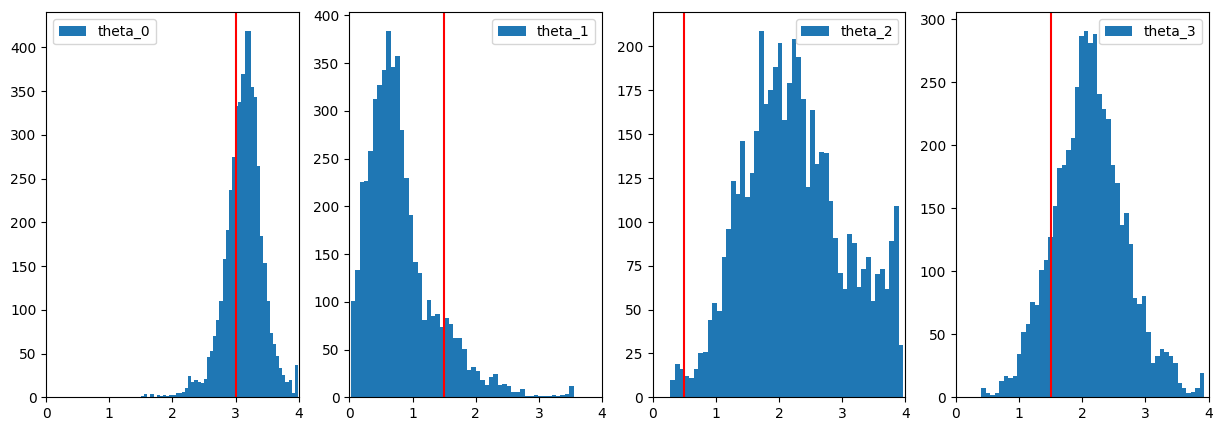

In [4]:
samples = bounded_trans.inverse_transform(op['samples_uncon'], use_torch=True)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5))

for idx, ax in enumerate(axes):
    ax.hist(samples[-5000:, idx].numpy(), bins=50, label=f"theta_{idx}")
    ax.set_xbound(lower=0,upper=4)
    ax.legend()
    ax.axvline(x=theta_true[idx].numpy(), c='r')

plt.show()